# ADS 509 Team 1 Final Project

## Tweets Classification on Cryptocurrencies

#### University of San Diego - Applied Data Science
#### Chow, Eva
#### Duan, Dingyi 
#### Tan, Abby

### Problem Statement:

As a new type of digital currencies in which transactions are verified and records maintained by a decentralized system using cryptography, cryptocurrencies are becoming more and more well-known and many categories have rised. We are interested in finding out what the featured texts and keywords are related to the five popular cryptocurrencies through twitter and how we are able to categorize them through text classification.


### Load Necessary Libraries

In [1]:
# import some necessary libraries

#!pip install psawimport datetime as dt
import os
import re
import nltk
import demoji
import random
import tweepy
import numpy as np
import pandas as pd
import seaborn as sns
import nltk.classify
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models
import warnings
warnings.filterwarnings("ignore")

from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import confusion_matrix
from collections import Counter, defaultdict
from lexical_diversity import lex_div as ld
from matplotlib import pyplot as plt
from datetime import datetime as dt
from sklearn.svm import LinearSVC
from nltk.corpus import stopwords
from wordcloud import WordCloud 
from string import punctuation
from sklearn import metrics

Using twitter API to retireve tweets regarding on our cryptocurrencies.

In [2]:
from api_keys import api_key, api_key_secret, bearer_token
client = tweepy.Client(bearer_token,wait_on_rate_limit=True)

In [3]:
# prepare our crypto candidates
handles = ["Bitcoin", "ethereum", "Cardano", "dogecoin", "ShibainuCoin"]
tweets_data = dict()

### Pulling Request Using Tweepy (using saved csv file after all tweets were downloaded)

In [84]:
# set up tweepy request
# pull max of 1000 tweets per crypto if possible
max_pulls = 10

for handle in handles:
    
    pulls = 0
    tweets_data[handle] = []
    user_obj = client.get_user(username=handle)
    
    for response in tweepy.Paginator(client.get_users_tweets,
                                     user_obj.data.id,
                                     max_results=100):
        
        print(pulls+1, "pulls completed for", handle)
        pulls += 1

        for tws in response.data:
            tweets_data[handle].append(tws.text)
        if 'next_token' in response.meta and pulls < max_pulls :
            next_token = response.meta['next_token']
        else : 
            break

1 pulls completed for Bitcoin
2 pulls completed for Bitcoin
3 pulls completed for Bitcoin
4 pulls completed for Bitcoin
5 pulls completed for Bitcoin
6 pulls completed for Bitcoin
7 pulls completed for Bitcoin
8 pulls completed for Bitcoin
9 pulls completed for Bitcoin
10 pulls completed for Bitcoin
1 pulls completed for ethereum
2 pulls completed for ethereum
3 pulls completed for ethereum
4 pulls completed for ethereum
5 pulls completed for ethereum
6 pulls completed for ethereum
7 pulls completed for ethereum
8 pulls completed for ethereum
9 pulls completed for ethereum
10 pulls completed for ethereum
1 pulls completed for Cardano
2 pulls completed for Cardano
3 pulls completed for Cardano
4 pulls completed for Cardano
5 pulls completed for Cardano
6 pulls completed for Cardano
7 pulls completed for Cardano
8 pulls completed for Cardano
9 pulls completed for Cardano
10 pulls completed for Cardano
1 pulls completed for dogecoin
2 pulls completed for dogecoin
3 pulls completed for dog

In [5]:
# store our tweets in a dataframe for convenience
tweets_df = (pd.DataFrame(tweets_data.items(), columns=['crypto_type', 'tweets'])).explode('tweets').reset_index(drop=True)
tweets_df

,crypto_type,tweets
0,Bitcoin,Stay focused. https://t.co/SONZh7NvYe
1,Bitcoin,Stack more sats. https://t.co/ivnb2W9ZgY
2,Bitcoin,A screenshot from December 2017. https://t.co/...
3,Bitcoin,Buy those sats and never give them back. https...
4,Bitcoin,https://t.co/rvmfGUSSys
...,...,...
4728,ShibainuCoin,$SHIB\nLet's build the strongest🐶community in ...
4729,ShibainuCoin,We are in #Coingecko \n\nhttps://t.co/E8YIc9cVu8
4730,ShibainuCoin,@TheMoonCarl $SHIB
4731,ShibainuCoin,Join the SHIB ARMY on Telegram\n\nhttps://t.co...


In [6]:
#tweets_df.to_csv('crypto_tweets.csv', sep='\t',index=False)

In [7]:
# load the tweets from previous saved file to save time
#tweets_df = pd.read_csv('D:/USD-ADS_graduate/ADS-509/Final_Project_Team1/ADS-509_Final_Project_Team1/crypto_tweets.csv',sep='\t')
tweets_df.shape

(4733, 2)

In [8]:
tweets_df['crypto_type'].value_counts().reset_index(name='number of tweets')

,index,number of tweets
0,ethereum,1000
1,Bitcoin,1000
2,Cardano,998
3,dogecoin,962
4,ShibainuCoin,773


### Cleaning Tweet

In [9]:
# punctuation variations
punctuation = set(punctuation) # speeds up comparison

tw_punct = punctuation #- {"#"} # remove hashtags from punctuation list

# stopwords
sw = stopwords.words("english")
sw = [i.replace("'","") for i in sw]  # remove single quote from sw

# remove retweet word

sw.extend(['rt', 'retweet'])

# we don't really need the actual names of the cryptos especially
# when the hashtags are removed
sw.extend(['bitcoin', 'ethereum', 'cardano','dogecoin','shib','shiba'])



# some useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")



def descriptive_stats(tokens,handle) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity (https://en.wikipedia.org/wiki/Lexical_diversity), 
        and num_tokens most common tokens. Return a list with the number of tokens, number
        of unique tokens, lexical diversity, and number of characters. 
    
    """

    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    lexical_diversity = ld.ttr(tokens)
    num_characters = sum([len(token) for token in tokens])
    top5_tokens = Counter(tokens).most_common()[:5]
    
    print("For", handle, ": \n")
    print(f"There are {num_tokens} tokens in the data.")
    print(f"There are {num_unique_tokens} unique tokens in the data.")
    print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    print(f"There are {num_characters} characters in the data.")
    print(f"These are the five most common tokens in the data: {top5_tokens}.")

    return "\n\n"

# text cleaning functions
def remove_url(s): 
    return re.sub(r'http\S+', '', s)

def lower_case(text):
    return text.casefold()
 
def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    return text.split()

def remove_stop(tokens) :
    # modify this function to remove stopwords
    tokens = [i for i in tokens if not i in sw]
    return tokens

def remove_emoji(tokens) :
    dem = demoji.findall(tokens)
    for item in dem.keys():
        tokens = tokens.replace(item, ' ')
    return tokens

# pipeline implementation
def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return tokens


### Tokenization and Normalization

**Cleaning steps** 

* remove urls
* Casefold to lowercase
* Remove punctuation other than hashtags
* Split on whitespace
* Remove stopwords
* Remove emoji

In [10]:
crypto_pipeline1 = [remove_url, lower_case, remove_punctuation, tokenize, remove_stop]
# crypto_pipeline = [remove_url, lower_case, remove_punctuation, tokenize, remove_stop]
tweets_df["tokens"] = tweets_df["tweets"].apply(prepare,pipeline=crypto_pipeline1)
tweets_df["num_tokens"] = tweets_df["tokens"].map(len) 

In [11]:
tweets_df

,crypto_type,tweets,tokens,num_tokens
0,Bitcoin,Stay focused. https://t.co/SONZh7NvYe,"[stay, focused]",2
1,Bitcoin,Stack more sats. https://t.co/ivnb2W9ZgY,"[stack, sats]",2
2,Bitcoin,A screenshot from December 2017. https://t.co/...,"[screenshot, december, 2017]",3
3,Bitcoin,Buy those sats and never give them back. https...,"[buy, sats, never, give, back]",5
4,Bitcoin,https://t.co/rvmfGUSSys,[],0
...,...,...,...,...
4728,ShibainuCoin,$SHIB\nLet's build the strongest🐶community in ...,"[lets, build, strongest🐶community, tweeter, hi...",8
4729,ShibainuCoin,We are in #Coingecko \n\nhttps://t.co/E8YIc9cVu8,[coingecko],1
4730,ShibainuCoin,@TheMoonCarl $SHIB,[themooncarl],1
4731,ShibainuCoin,Join the SHIB ARMY on Telegram\n\nhttps://t.co...,"[join, army, telegram]",3


### Calculate Descriptive Statistics On the Cryptos Tokens.

In [12]:
for handle in handles:
    token_sum = []
    start_index = tweets_df['crypto_type'].ne(handle).idxmin()
    end_index = len(tweets_df.loc[tweets_df['crypto_type'] == handle])
    for i in range(start_index, start_index+end_index):
        token_row = tweets_df['tokens'].loc[tweets_df['crypto_type'] == handle][i] 
        token_sum = token_sum + token_row # use + to stitch all list together
    print(descriptive_stats(token_sum, handle))

For Bitcoin : 

There are 9328 tokens in the data.
There are 4079 unique tokens in the data.
The lexical diversity is 0.437 in the data.
There are 56586 characters in the data.
These are the five most common tokens in the data: [('btc', 67), ('price', 60), ('market', 49), ('inflation', 44), ('2021', 42)].



For ethereum : 

There are 12521 tokens in the data.
There are 4194 unique tokens in the data.
The lexical diversity is 0.335 in the data.
There are 77086 characters in the data.
These are the five most common tokens in the data: [('latest', 144), ('new', 135), ('eth2', 125), ('week', 118), ('news', 103)].



For Cardano : 

There are 12625 tokens in the data.
There are 4062 unique tokens in the data.
The lexical diversity is 0.322 in the data.
There are 87937 characters in the data.
These are the five most common tokens in the data: [('cardanostiftung', 229), ('cardanocommunity', 223), ('blockchain', 143), ('join', 112), ('amp', 108)].



For dogecoin : 

There are 9556 tokens in 

### Build Word Clouds For All The Cryptos. 

In [13]:
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if sw is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in sw}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")

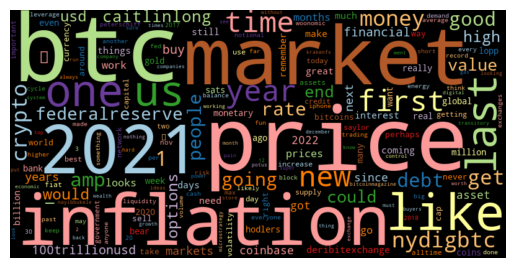

In [14]:
wc1 = count_words(tweets_df.loc[tweets_df['crypto_type'] == 'Bitcoin'], column='tokens', preprocess=None, min_freq=2)
wordcloud(wc1['freq'], title=None, max_words=200, stopwords=None)

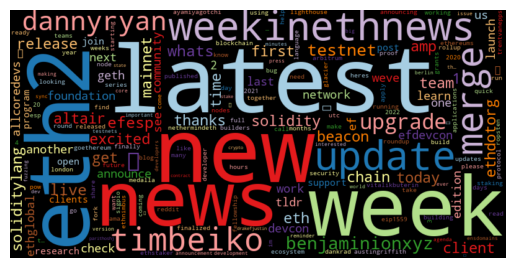

In [15]:
wc2 = count_words(tweets_df.loc[tweets_df['crypto_type'] == 'ethereum'], column='tokens', preprocess=None, min_freq=2)
wordcloud(wc2['freq'], title=None, max_words=200, stopwords=None)

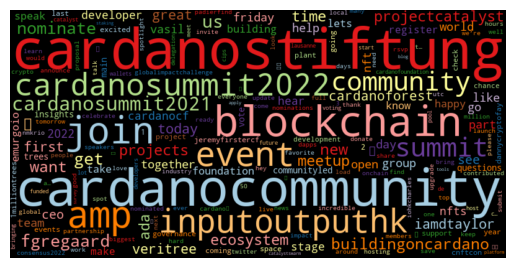

In [16]:
wc3 = count_words(tweets_df.loc[tweets_df['crypto_type'] == 'Cardano'], column='tokens', preprocess=None, min_freq=2)
wordcloud(wc3['freq'], title=None, max_words=200, stopwords=None)

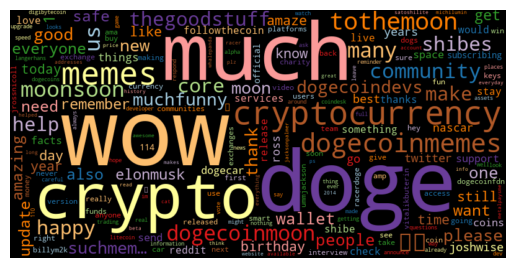

In [17]:
wc4 = count_words(tweets_df.loc[tweets_df['crypto_type'] == 'dogecoin'], column='tokens', preprocess=None, min_freq=2)
wordcloud(wc4['freq'], title=None, max_words=200, stopwords=None)

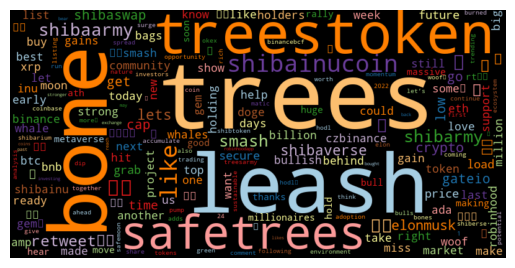

In [18]:
wc5 = count_words(tweets_df.loc[tweets_df['crypto_type'] == 'ShibainuCoin'], column='tokens', preprocess=None, min_freq=2)
wordcloud(wc5['freq'], title=None, max_words=200, stopwords=None)

### Classification Models

In [19]:
all_tokens = []
for i in tweets_df['tokens']:
    all_tokens += i

# look at some random sampling tokens
print(random.sample(all_tokens, 20))

['🚀', '🇺🇸', 'fuzz', 'price', 'crypto', 'soars', 'exchange', 'transaction', 'screenshot', 'venue', '🐕', '🔥', '•', '1ð1ð', '🚨🚨🚨', '😬', 'today', 'hard', 'shibaverse', 'enhancements']


In [20]:
word_cutoff = 5
word_dist = nltk.FreqDist(all_tokens)
feature_words = set()

for word, count in word_dist.items() :
    if count > word_cutoff :
        feature_words.add(word)
        
print(f"With a word cutoff of {word_cutoff}, we have {len(feature_words)} as features in the model (including emojis).")

With a word cutoff of 5, we have 1811 as features in the model (including emojis).


In [21]:
# look at some random sampling feature words
print(random.sample(feature_words, 20))

['course', 'buying', 'october', 'win', 'ever', 'improvement', 'globalimpactchallenge', 'utility', 'code', 'rally', 'track', 'spread', 'peterszilagyi', 'hour', 'hosting', 'products', 'vote', 'episode', 'gone', 'verification']


In [22]:
def conv_features(text,fw) :
    
    ret_word = [i for i in text]
    ret_bool = [True if i in fw else False for i in text]
    
    ret_dict = dict(zip(ret_word,ret_bool))
    
    return(ret_dict)

In [23]:
convention_data = [[tweets_df['tokens'][i], tweets_df['crypto_type'][i]] for i in range(len(tweets_df))]

In [24]:
featuresets = [(conv_features(tokens,feature_words), crypto) for (tokens, crypto) in convention_data]

Each of the tweet contains a feature set, let's print some feature sets

In [25]:
print(featuresets[:3])

[({'stay': True, 'focused': True}, 'Bitcoin'), ({'stack': True, 'sats': True}, 'Bitcoin'), ({'screenshot': False, 'december': True, '2017': True}, 'Bitcoin')]


In [26]:
random.seed(1314)
random.shuffle(featuresets)

# choose train:test = 7:3 
test_size = round(len(featuresets)*(3/10))
test_size

1420

#### Naive Bayes
##### 1. With emoji

In [27]:
test_set, train_set = featuresets[:test_size], featuresets[test_size:]
classifier = nltk.NaiveBayesClassifier.train(train_set)
print('The training set accuracy for Naive Bayes model with emojis is:',round(nltk.classify.accuracy(classifier, train_set),3))

The training set accuracy for Naive Bayes model with emojis is: 0.952


Let's look at the top 25 most informative features/tokens of our model

In [28]:
classifier.show_most_informative_features(25)

Most Informative Features
                   trees = True           Shibai : dogeco =    343.2 : 1.0
                      ❤️ = True           Shibai : ethere =    180.1 : 1.0
                       💎 = True           Shibai : ethere =    161.9 : 1.0
                       🌳 = True           Shibai : ethere =    135.9 : 1.0
                     wow = True           dogeco : ethere =    106.8 : 1.0
        cardanocommunity = True           Cardan : Shibai =     85.7 : 1.0
                    doge = True           dogeco : ethere =     82.4 : 1.0
                    much = True           dogeco : ethere =     80.9 : 1.0
                       🔥 = True           Shibai : Bitcoi =     63.1 : 1.0
                    join = True           Cardan : Bitcoi =     57.3 : 1.0
         cardanostiftung = True           Cardan : Shibai =     54.2 : 1.0
                     low = True           Shibai : Cardan =     50.8 : 1.0
              blockchain = True           Cardan : Shibai =     49.7 : 1.0

For the 25 most informative features, 6 of them are emojis and top5 features have 3 emojis!

All of them emoji features are pointing out that for Shiba Inu's tweets are symbolic for its use of emojis.

Let's run some prediction on the test set

In [29]:
cryptos = handles
results = defaultdict(lambda: defaultdict(int))

random.shuffle(test_set)

for idx, tp in enumerate(test_set) :
    tokens, crypto = tp    
    # Now do the same thing as above, but we store the results rather
    # than printing them. 
   
    # get the estimated party
    estimated_crypto = classifier.classify(conv_features(tokens,feature_words))
    
    results[crypto][estimated_crypto] += 1


In [30]:
results

defaultdict(<function __main__.<lambda>()>,
            {'dogecoin': defaultdict(int,
                         {'dogecoin': 233,
                          'ShibainuCoin': 36,
                          'Bitcoin': 8,
                          'ethereum': 22,
                          'Cardano': 5}),
             'ethereum': defaultdict(int,
                         {'ethereum': 265,
                          'Cardano': 13,
                          'Bitcoin': 2,
                          'ShibainuCoin': 8,
                          'dogecoin': 2}),
             'Cardano': defaultdict(int,
                         {'ShibainuCoin': 11,
                          'Cardano': 278,
                          'ethereum': 10,
                          'Bitcoin': 1}),
             'Bitcoin': defaultdict(int,
                         {'Bitcoin': 173,
                          'ethereum': 45,
                          'ShibainuCoin': 55,
                          'Cardano': 15,
                      

Let's look at some confusion matrix for better visual

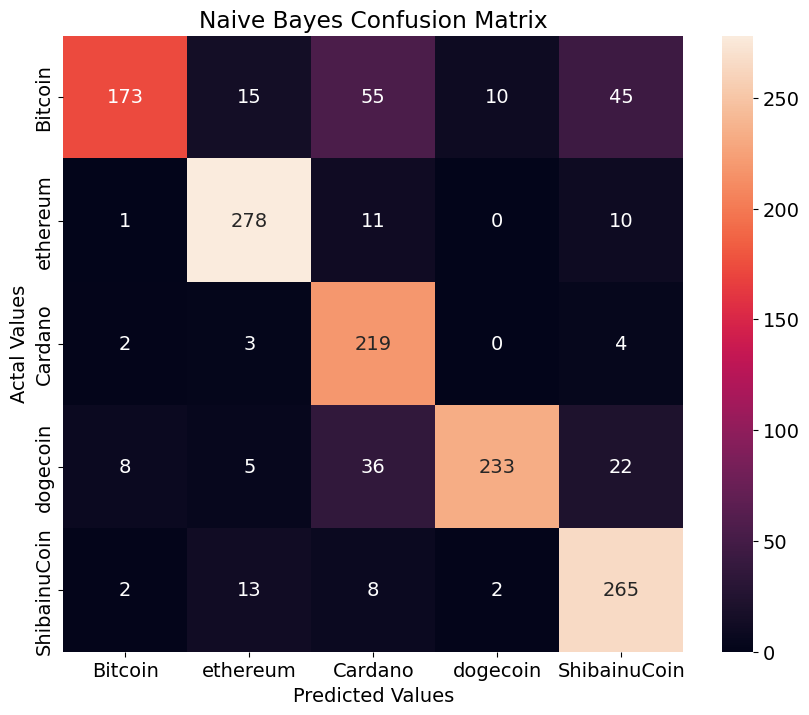



The test set accuracy of Naive Bayes model with emojis: 0.823


In [31]:
actual = [test_set[i][1] for i in range(len(test_set))]
predicted = [classifier.classify(conv_features(test_set[i][0],feature_words)) for i in range(len(test_set))] 

cm = confusion_matrix(actual, predicted)

# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm, index = handles, columns = handles)

#Plotting the confusion matrix
font = {'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)
plt.figure(figsize=(10,8))
sns.heatmap(cm_df, annot=True,fmt='g')
plt.title('Naive Bayes Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

def compute_accuracy(y_true, y_pred):
    correct_predictions = 0
    # iterate over each label and check
    for true, predicted in zip(y_true, y_pred):
        if true == predicted:
            correct_predictions += 1
    # compute the accuracy
    accuracy = correct_predictions/len(y_true)
    return accuracy
print('\n')
print("The test set accuracy of Naive Bayes model with emojis:", round(compute_accuracy(actual, predicted),3))

Accuracy of 0.959 for training and 0.829 for test is very good for our model performance.

We suspect that the emojis are playing a significant role in the model performance as they can be unique to certain type of coins.

We will now remove the emojis and see if our hypothesis is correct.

##### 2. Without emoji

In [32]:
# a different pipeline including remove_emoji 
crypto_pipeline2 = [remove_url, lower_case, remove_punctuation, remove_emoji, tokenize, remove_stop]

# add a new column for tokens without emojis
tweets_df["tokens_no_emoji"] = tweets_df["tweets"].apply(prepare,pipeline=crypto_pipeline2)

In [33]:
all_tokens_no_emoji = []
for i in tweets_df['tokens_no_emoji']:
    all_tokens_no_emoji += i

# look at some random sampling tokens
print(random.sample(all_tokens_no_emoji, 20))

['wow', 'price', 'memes', 'fud', 'interest', 'great', 'overtakes', 'elonmusk', 'who’s', 'assets', 'price', 'first', 'returns', 'regular', 'never', 'hey', 'gateio', 'seems', 'events', 'early']


In [34]:
word_cutoff = 5
word_dist = nltk.FreqDist(all_tokens_no_emoji)
feature_words_no_emoji = set()

for word, count in word_dist.items() :
    if count > word_cutoff :
        feature_words_no_emoji.add(word)
        
print(f"With a word cutoff of {word_cutoff}, we have {len(feature_words_no_emoji)} as features in the model (without emojis).")

With a word cutoff of 5, we have 1720 as features in the model (without emojis).


Compared to 1812 features with emojis included, we removed 89 emojis from the feature sets

In [35]:
convention_data_no_emoji = [[tweets_df['tokens_no_emoji'][i], tweets_df['crypto_type'][i]] for i in range(len(tweets_df))]
featuresets_no_emoji = [(conv_features(tokens,feature_words_no_emoji), crypto) for (tokens, crypto) in convention_data_no_emoji]

In [36]:
random.seed(1314)
random.shuffle(featuresets)

# choose train:test = 7:3 
test_size_no_emoji = round(len(featuresets_no_emoji)*(3/10))
test_size_no_emoji

1420

In [37]:
test_set_no_emoji, train_set_no_emoji = featuresets_no_emoji[:test_size_no_emoji], featuresets_no_emoji[test_size_no_emoji:]
classifier_no_emoji = nltk.NaiveBayesClassifier.train(train_set_no_emoji)
print('The training set accuracy for Naive Bayes model without emojis is:"',round(nltk.classify.accuracy(classifier_no_emoji, train_set),3))

The training set accuracy for Naive Bayes model without emojis is:" 0.764


In [38]:
classifier_no_emoji.show_most_informative_features(25)

Most Informative Features
                   trees = True           Shibai : ethere =    296.5 : 1.0
        cardanocommunity = True           Cardan : Shibai =    117.0 : 1.0
                     low = True           Shibai : Cardan =     72.7 : 1.0
                    doge = True           dogeco : ethere =     71.4 : 1.0
         cardanostiftung = True           Cardan : Shibai =     70.5 : 1.0
                     cap = True           Shibai : dogeco =     69.3 : 1.0
                     wow = True           dogeco : Shibai =     66.1 : 1.0
                    grab = True           Shibai : Cardan =     58.1 : 1.0
                   price = True           Shibai : Cardan =     56.4 : 1.0
                  secure = True           Shibai : dogeco =     52.7 : 1.0
                  latest = True           ethere : dogeco =     52.0 : 1.0
                    load = True           Shibai : dogeco =     49.4 : 1.0
                    like = True           Shibai : ethere =     41.3 : 1.0

In [39]:
cryptos = handles
results = defaultdict(lambda: defaultdict(int))

random.shuffle(test_set)

for idx, tp in enumerate(test_set) :
    tokens, crypto = tp    
    # Now do the same thing as above, but we store the results rather
    # than printing them. 
   
    # get the estimated party
    estimated_crypto_no_emoji = classifier_no_emoji.classify(conv_features(tokens,feature_words_no_emoji))
    
    results[crypto][estimated_crypto_no_emoji] += 1


In [40]:
results

defaultdict(<function __main__.<lambda>()>,
            {'Cardano': defaultdict(int,
                         {'Cardano': 295, 'ethereum': 2, 'ShibainuCoin': 3}),
             'ShibainuCoin': defaultdict(int,
                         {'ShibainuCoin': 224, 'dogecoin': 2, 'Cardano': 2}),
             'Bitcoin': defaultdict(int,
                         {'Cardano': 83,
                          'ShibainuCoin': 137,
                          'dogecoin': 40,
                          'ethereum': 38}),
             'dogecoin': defaultdict(int,
                         {'dogecoin': 290,
                          'ShibainuCoin': 8,
                          'Cardano': 5,
                          'ethereum': 1}),
             'ethereum': defaultdict(int,
                         {'ethereum': 272,
                          'ShibainuCoin': 3,
                          'Cardano': 14,
                          'dogecoin': 1})})

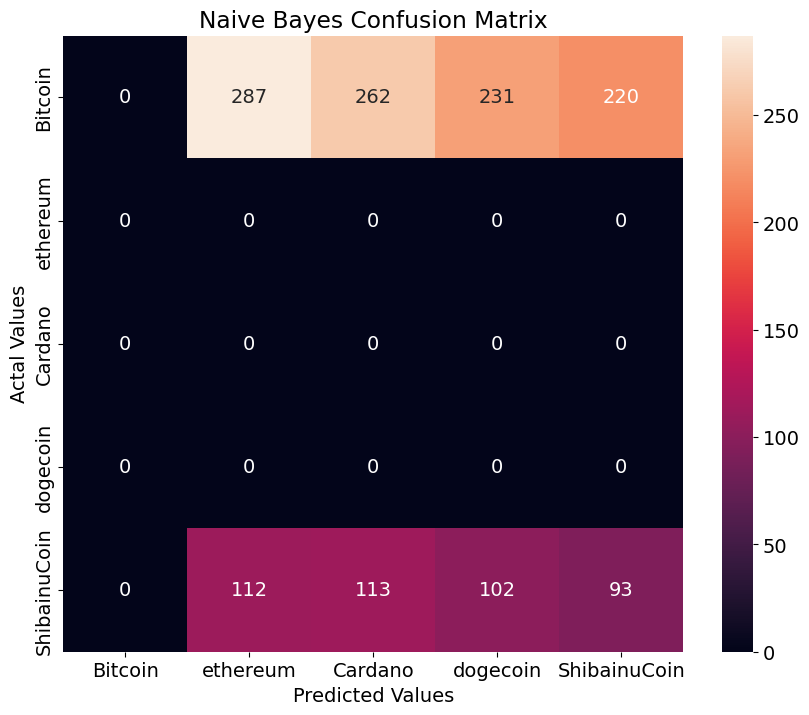



The test set accuracy of Naive Bayes model without emojis: 0.065


In [41]:
actual_no_emoji = [test_set_no_emoji[i][1] for i in range(len(test_set_no_emoji))]
predicted_no_emoji = [classifier_no_emoji.classify(conv_features(test_set[i][0],feature_words_no_emoji)) for i in range(len(test_set_no_emoji))] 

cm_no_emoji = confusion_matrix(actual_no_emoji, predicted_no_emoji)

# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df_no_emoji = pd.DataFrame(cm_no_emoji, index = handles, columns = handles)

#Plotting the confusion matrix
font = {'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)
plt.figure(figsize=(10,8))
sns.heatmap(cm_df_no_emoji, annot=True,fmt='g')
plt.title('Naive Bayes Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

print('\n')
print("The test set accuracy of Naive Bayes model without emojis:", round(compute_accuracy(actual_no_emoji, predicted_no_emoji),3))

WOW! With an accuracy score on training set of 0.767 and less than 0.1 on test set of mere 0.072, our model could barely recognize anything cryptocurrency using words alone without any emojis!

This results confirms that our hypothesis is proven to be correct and it is a learnt fact that emojis are indeed a key factor for classifying different cryptocurrencies.

#### SVM

In [42]:
classifier_svm = nltk.classify.SklearnClassifier(LinearSVC())
classifier_svm.train(train_set)
print('The training set accuracy for SVM model is:',round(nltk.classify.accuracy(classifier_svm, train_set),3))

The training set accuracy for SVM model is: 0.983


In [43]:
cryptos = handles
results = defaultdict(lambda: defaultdict(int))

random.shuffle(test_set)

for idx, tp in enumerate(test_set) :
    tokens, crypto = tp    
    # Now do the same thing as above, but we store the results rather
    # than printing them. 
   
    # get the estimated party
    estimated_crypto = classifier_svm.classify(conv_features(tokens,feature_words))
    
    results[crypto][estimated_crypto] += 1

In [44]:
results

defaultdict(<function __main__.<lambda>()>,
            {'dogecoin': defaultdict(int,
                         {'dogecoin': 226,
                          'ethereum': 12,
                          'Bitcoin': 57,
                          'Cardano': 4,
                          'ShibainuCoin': 5}),
             'ethereum': defaultdict(int,
                         {'ethereum': 242,
                          'dogecoin': 16,
                          'ShibainuCoin': 2,
                          'Bitcoin': 24,
                          'Cardano': 6}),
             'Bitcoin': defaultdict(int,
                         {'Bitcoin': 264,
                          'dogecoin': 25,
                          'ShibainuCoin': 2,
                          'Cardano': 4,
                          'ethereum': 3}),
             'Cardano': defaultdict(int,
                         {'ethereum': 14,
                          'Cardano': 249,
                          'dogecoin': 12,
                          

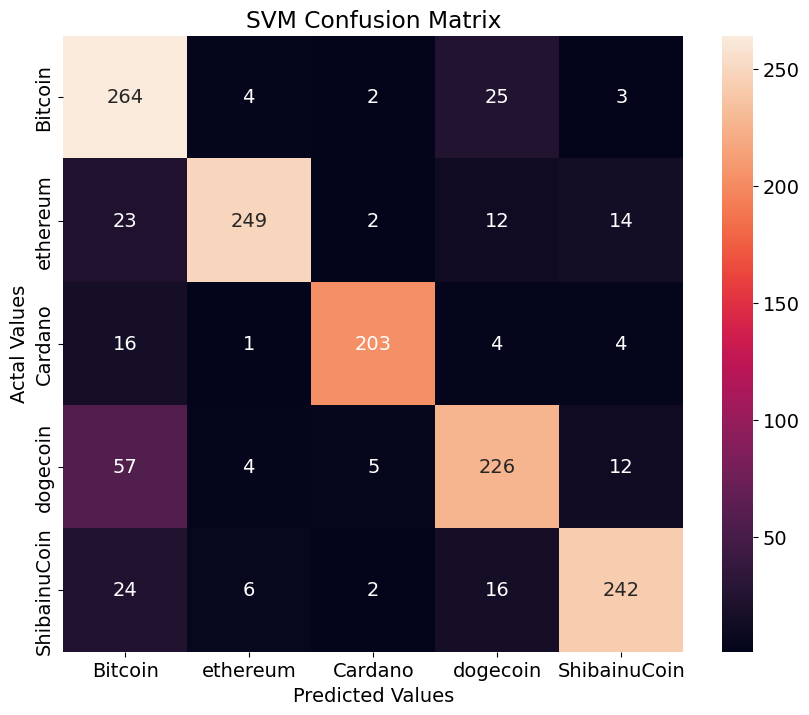



The test set accuracy of SVM model is: 0.834


In [45]:
actual_svm = [test_set[i][1] for i in range(len(test_set))]
predicted_svm = [classifier_svm.classify(conv_features(test_set[i][0],feature_words)) for i in range(len(test_set))] 

cm_svm = confusion_matrix(actual_svm, predicted_svm)

# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_svm_df = pd.DataFrame(cm_svm, index = handles, columns = handles)

#Plotting the confusion matrix
font = {'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)
plt.figure(figsize=(10,8))
sns.heatmap(cm_svm_df, annot=True,fmt='g')
plt.title('SVM Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

print('\n')
print("The test set accuracy of SVM model is:", round(compute_accuracy(actual_svm, predicted_svm),3))

In [46]:
class_compare = pd.DataFrame({
                            'Models': ['Naive Bayes', 'SVM'],
                            'Training Accuracy': [round(nltk.classify.accuracy(classifier, train_set),3), round(nltk.classify.accuracy(classifier_svm, train_set),3)],
                            'Test Accuracy': [round(compute_accuracy(actual, predicted),3), round(compute_accuracy(actual_svm, predicted_svm),3)]
                             })
class_compare

,Models,Training Accuracy,Test Accuracy
0,Naive Bayes,0.952,0.823
1,SVM,0.983,0.834


Both models have been performing with acceptable result and SVM outperforms Naive Bayes slightly with 0.981 of training accuracy and 0.853 test accuracy.

### Topic Modeling

In [47]:
tweets_df.head()

,crypto_type,tweets,tokens,num_tokens,tokens_no_emoji
0,Bitcoin,Stay focused. https://t.co/SONZh7NvYe,"[stay, focused]",2,"[stay, focused]"
1,Bitcoin,Stack more sats. https://t.co/ivnb2W9ZgY,"[stack, sats]",2,"[stack, sats]"
2,Bitcoin,A screenshot from December 2017. https://t.co/...,"[screenshot, december, 2017]",3,"[screenshot, december, 2017]"
3,Bitcoin,Buy those sats and never give them back. https...,"[buy, sats, never, give, back]",5,"[buy, sats, never, give, back]"
4,Bitcoin,https://t.co/rvmfGUSSys,[],0,[]


In [48]:
# Let's add some helpful columns on the df
tweets_df['char_len'] = tweets_df['tweets'].apply(len)
tweets_df['word_len'] = tweets_df['tweets'].apply(lambda x: len(x.split()))
tweets_df.head()

,crypto_type,tweets,tokens,num_tokens,tokens_no_emoji,char_len,word_len
0,Bitcoin,Stay focused. https://t.co/SONZh7NvYe,"[stay, focused]",2,"[stay, focused]",37,3
1,Bitcoin,Stack more sats. https://t.co/ivnb2W9ZgY,"[stack, sats]",2,"[stack, sats]",40,4
2,Bitcoin,A screenshot from December 2017. https://t.co/...,"[screenshot, december, 2017]",3,"[screenshot, december, 2017]",56,6
3,Bitcoin,Buy those sats and never give them back. https...,"[buy, sats, never, give, back]",5,"[buy, sats, never, give, back]",64,9
4,Bitcoin,https://t.co/rvmfGUSSys,[],0,[],23,1


<AxesSubplot:title={'center':'Average Tweet Length Comparison'}, xlabel='crypto_type', ylabel='Counts'>

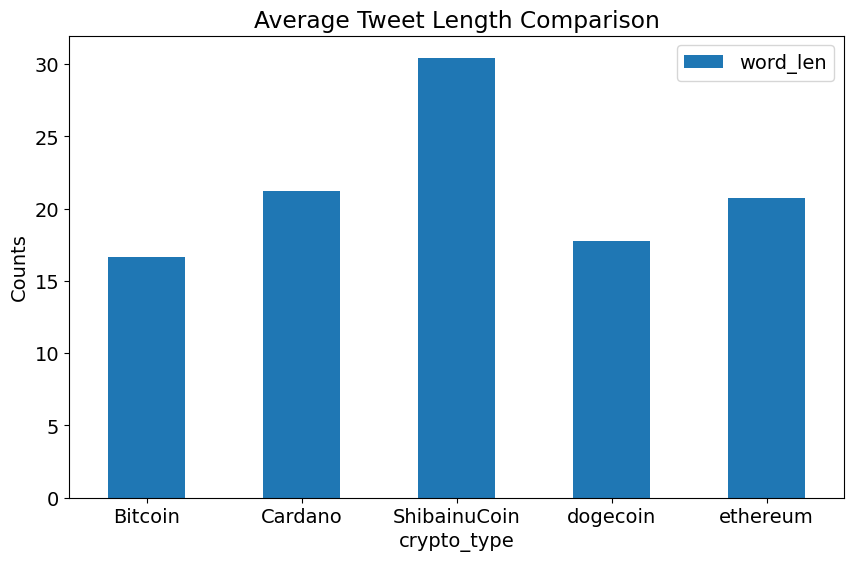

In [49]:
%matplotlib inline
# checking to see which crypto has the most words
tweets_df.groupby('crypto_type').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6), rot = 0,ylabel = 'Counts',title = 'Average Tweet Length Comparison')

Shiba Inu has the longest average tweet length while Bitcoin has surprisingly the shortest!

#### Count and TF-IDF vectorizations.

In [50]:
# using a cutoff of minimum of 5 words and 70% as maximum.
count_tweet_vectorizer = CountVectorizer(stop_words=sw, min_df=5, max_df=0.7)
count_tweet_vectors = count_tweet_vectorizer.fit_transform(tweets_df["tweets"])
count_tweet_vectors.shape

(4733, 1938)

In [51]:
pd.DataFrame(count_tweet_vectors.todense())

,0,1,2,3,4,5,6,7,8,9,...,1928,1929,1930,1931,1932,1933,1934,1935,1936,1937
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4728,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4729,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4730,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4731,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
tfidf_tweet_vectorizer = TfidfVectorizer(stop_words=sw, min_df=5, max_df=0.7)
tfidf_tweet_vectors = tfidf_tweet_vectorizer.fit_transform(tweets_df['tweets'])
tfidf_tweet_vectors.shape

(4733, 1938)

In [53]:
pd.DataFrame(tfidf_tweet_vectors.todense())

,0,1,2,3,4,5,6,7,8,9,...,1928,1929,1930,1931,1932,1933,1934,1935,1936,1937
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4728,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4729,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4731,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The `count_tweet_vectors` holds the absolute counts for each word in different corpura while
the TfidfTransformer (`tfidf_tweet_vectors`) holds tf-idf scores which are the term frequencies within a document *scaled* by how common that word is in the entire corpus.

The two topic-document matrice can help understand the dimensionality of the keywords and documents.

#### Display Topics Function

In [54]:
def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print(" %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

#### Non-Negative Matrix Factorization

In [55]:
nmf_tweet_model = NMF(n_components=5, random_state=314)
W_tweet_matrix = nmf_tweet_model.fit_transform(tfidf_tweet_vectors)
H_tweet_matrix = nmf_tweet_model.components_

In [56]:
display_topics(nmf_tweet_model, tfidf_tweet_vectorizer.get_feature_names())


Topic 00
 https (26.97)
 co (25.92)
 doge (0.48)
 got (0.44)
 go (0.44)

Topic 01
 trees (3.58)
 leash (3.16)
 bone (3.16)
 trees_token (3.11)
 safetrees (2.81)

Topic 02
 doge (7.81)
 wow (7.63)
 dogecoinmemes (7.28)
 memes (7.27)
 tothemoon (7.24)

Topic 03
 http (13.03)
 much (11.50)
 wow (9.50)
 co (4.49)
 many (1.42)

Topic 04
 cardanocommunity (1.60)
 cardanostiftung (1.22)
 latest (1.05)
 week (1.03)
 blockchain (1.00)


In [57]:
nmf_W_tweet_matrix = pd.DataFrame(W_tweet_matrix)
nmf_W_tweet_matrix.columns = ['Topic 00', 'Topic 01', 'Topic 02', 'Topic 03', 'Topic 04']
nmf_W_tweet_matrix['Topic'] = nmf_W_tweet_matrix.idxmax(axis=1)

In [58]:
nmf_topic = pd.concat([nmf_W_tweet_matrix[['Topic']], tweets_df[['crypto_type']]], axis=1 )

In [59]:
nmf_topic.head(3)

,Topic,crypto_type
0,Topic 00,Bitcoin
1,Topic 00,Bitcoin
2,Topic 00,Bitcoin


In [60]:
nmf_topic.groupby('Topic')['crypto_type'].value_counts()

Topic     crypto_type 
Topic 00  Bitcoin         650
          dogecoin        256
          ethereum        231
          Cardano         164
          ShibainuCoin     77
Topic 01  ShibainuCoin    655
          Bitcoin          40
          dogecoin         15
          Cardano          14
          ethereum         11
Topic 02  dogecoin        131
          Bitcoin          19
          ShibainuCoin     10
          Cardano           6
          ethereum          4
Topic 03  dogecoin        338
          Bitcoin          24
          ethereum          8
          Cardano           5
          ShibainuCoin      2
Topic 04  Cardano         809
          ethereum        746
          Bitcoin         267
          dogecoin        222
          ShibainuCoin     29
Name: crypto_type, dtype: int64

#### Latent Semantic Analysis

In [61]:
svd_tweet_model = TruncatedSVD(n_components=5, n_iter=7, random_state=314)
svd_W_tweet_matrix = svd_tweet_model.fit_transform(tfidf_tweet_vectors)
svd_H_tweet_matrix = svd_tweet_model.components_

In [62]:
display_topics(svd_tweet_model, tfidf_tweet_vectorizer.get_feature_names())


Topic 00
 https (11.12)
 co (10.96)
 trees (0.85)
 like (0.74)
 wow (0.71)

Topic 01
 trees (3.29)
 leash (2.91)
 bone (2.90)
 trees_token (2.87)
 safetrees (2.59)

Topic 02
 wow (10.84)
 doge (6.12)
 http (5.01)
 much (4.96)
 crypto (4.90)

Topic 03
 http (15.34)
 much (12.68)
 wow (4.54)
 co (1.86)
 update (1.63)

Topic 04
 cardanocommunity (1.70)
 cardanostiftung (1.36)
 latest (1.21)
 week (1.18)
 news (1.14)


In [63]:
svd_W_tweet_matrix = pd.DataFrame(svd_W_tweet_matrix)
svd_W_tweet_matrix.columns = ['Topic 00', 'Topic 01', 'Topic 02', 'Topic 03', 'Topic 04']
svd_W_tweet_matrix['Topic'] = svd_W_tweet_matrix.idxmax(axis=1)

In [64]:
svd_topic = pd.concat([svd_W_tweet_matrix[['Topic']], tweets_df[['crypto_type']]], axis=1 )
svd_topic.head(3)

,Topic,crypto_type
0,Topic 00,Bitcoin
1,Topic 00,Bitcoin
2,Topic 00,Bitcoin


In [65]:
svd_topic.groupby('Topic')['crypto_type'].value_counts()

Topic     crypto_type 
Topic 00  Bitcoin         697
          dogecoin        347
          ethereum        316
          Cardano         307
          ShibainuCoin    136
Topic 01  ShibainuCoin    617
          Bitcoin          61
          Cardano          23
          dogecoin         20
          ethereum         17
Topic 02  dogecoin        229
          Bitcoin          14
          Cardano           9
          ethereum          5
          ShibainuCoin      3
Topic 03  dogecoin        191
          Bitcoin          15
          ethereum          7
          Cardano           2
          ShibainuCoin      1
Topic 04  Cardano         657
          ethereum        655
          Bitcoin         213
          dogecoin        175
          ShibainuCoin     16
Name: crypto_type, dtype: int64

#### Latent Dirichlet Allocation

In [66]:
lda_tweet_model = LatentDirichletAllocation(n_components=5, random_state=314)
lda_W_tweet_matrix = lda_tweet_model.fit_transform(count_tweet_vectors)
lda_H_tweet_matrix = lda_tweet_model.components_

In [67]:
display_topics(lda_tweet_model, tfidf_tweet_vectorizer.get_feature_names())


Topic 00
 wow (4.19)
 doge (3.86)
 crypto (2.87)
 cryptocurrency (1.77)
 memes (1.43)

Topic 01
 co (12.85)
 https (10.94)
 http (2.15)
 new (1.44)
 much (1.29)

Topic 02
 week (1.71)
 first (1.33)
 latest (1.29)
 news (1.27)
 year (1.25)

Topic 03
 https (6.15)
 co (6.12)
 trees (4.23)
 like (2.92)
 leash (2.91)

Topic 04
 https (6.12)
 co (5.99)
 cardanostiftung (2.13)
 cardanocommunity (1.69)
 blockchain (1.67)


In [68]:
lda_W_tweet_matrix = pd.DataFrame(lda_W_tweet_matrix)
lda_W_tweet_matrix.columns = ['Topic 00', 'Topic 01', 'Topic 02', 'Topic 03', 'Topic 04']
lda_W_tweet_matrix['Topic'] = lda_W_tweet_matrix.idxmax(axis=1)

In [69]:
lda_topic = pd.concat([lda_W_tweet_matrix[['Topic']], tweets_df[['crypto_type']]], axis=1 )
lda_topic.head(3)

,Topic,crypto_type
0,Topic 01,Bitcoin
1,Topic 03,Bitcoin
2,Topic 02,Bitcoin


In [70]:
lda_topic.groupby('Topic')['crypto_type'].value_counts()

Topic     crypto_type 
Topic 00  dogecoin        317
          Bitcoin          94
          ethereum         39
          Cardano          31
          ShibainuCoin     15
Topic 01  dogecoin        434
          ethereum        422
          Bitcoin         273
          Cardano         178
          ShibainuCoin     17
Topic 02  ethereum        409
          Bitcoin         202
          Cardano          63
          dogecoin         58
          ShibainuCoin      6
Topic 03  ShibainuCoin    721
          Bitcoin         250
          dogecoin         44
          Cardano          14
          ethereum         13
Topic 04  Cardano         712
          Bitcoin         181
          ethereum        117
          dogecoin        109
          ShibainuCoin     14
Name: crypto_type, dtype: int64

In [71]:
lda_display = pyLDAvis.sklearn.prepare(lda_tweet_model, count_tweet_vectors, count_tweet_vectorizer, sort_topics=False)

In [72]:
pyLDAvis.display(lda_display)

In the three topic models we can see that dogecoin has appeared twice in all of the models indicating the keywords used by dogecoin community can be more general than the other cryptocurrencies while coins like shiba inu has some unique keywords from previous word clouds such as "tree", "leash" and "bones".

To choose the optimal topic model, we want to make sure that the keywords in each topic actually match the corresponding coin without interfering with others. Thus, the Non-Negative Matrix Factorization seems to be the most accurate among all three topic models based on the clusering through keywords.

### Sentiment Assignment

##### Data prep for sentiment words and emojis

In [73]:
# sentiment data
folder_path = os.getcwd() + '\\sentiment\\'
positive_words_file = folder_path + "positive-words.txt"
negative_words_file = folder_path + "negative-words.txt"
tidy_text_file = folder_path + "tidytext_sentiments.txt"
emoji_file = folder_path + 'Emoji_Sentiment_Data_v1.0.csv'

In [74]:
pos_words = pd.read_csv(positive_words_file, sep='\t', encoding='latin-1')
neg_words = pd.read_csv(negative_words_file, sep='\t', encoding='latin-1')
tidy_sen = pd.read_csv(tidy_text_file, sep='\t', encoding='latin-1')
df_emoji_sen = pd.read_csv(emoji_file)

In [75]:
# positive and negative words
pos_words = pos_words[33:]
neg_words = neg_words[33:]
pos_words['score'] = 1
neg_words['score'] = -1
pos_words.columns = ['word','score']
neg_words.columns = ['word','score']

# tidy sentiments
tidy_sen['score'] = np.where(tidy_sen['sentiment'] == 'positive', 1, -1)
tidy_sen = tidy_sen[['word','score']]

In [76]:
# emoji
df_emoji_sen['sentiment'] = df_emoji_sen[['Negative','Neutral','Positive']].idxmax(axis=1)
df_emoji_sen = df_emoji_sen[df_emoji_sen['sentiment'] != 'Neutral']

df_emoji_sen['score'] = np.where(df_emoji_sen['sentiment'] == 'Positive', 1, -1)
df_emoji_sen = df_emoji_sen[['Emoji', 'score']]

df_emoji_sen.columns = ['word', 'score']

In [77]:
# merge
df_sen = pd.concat([pos_words, neg_words, tidy_sen, df_emoji_sen], axis=0)
df_sen = df_sen.drop_duplicates().reset_index(drop=True)
df_sen.shape

(12128, 2)

In [78]:
# convert to dictionary
sen_word = df_sen['word'].to_list()
sen_score = df_sen['score'].to_list()
word_dict = dict(zip(sen_word, sen_score))

##### Sentiment score function

In [79]:
# sentiment score
def sen_score(text):
    sentiment_score = 0
    for word in text:
        if word in word_dict:
            sentiment_score += word_dict[word]
    return sentiment_score / (len(text) or not len(text))

In [80]:
tweets_df['tweets_score'] = tweets_df['tokens'].apply(sen_score)
tweets_df.head(3)

,crypto_type,tweets,tokens,num_tokens,tokens_no_emoji,char_len,word_len,tweets_score
0,Bitcoin,Stay focused. https://t.co/SONZh7NvYe,"[stay, focused]",2,"[stay, focused]",37,3,0.0
1,Bitcoin,Stack more sats. https://t.co/ivnb2W9ZgY,"[stack, sats]",2,"[stack, sats]",40,4,0.0
2,Bitcoin,A screenshot from December 2017. https://t.co/...,"[screenshot, december, 2017]",3,"[screenshot, december, 2017]",56,6,0.0


##### Average sentiment score for crypto type

In [81]:
tweets_df.groupby(['crypto_type'])['tweets_score'].mean()

crypto_type
Bitcoin         0.039645
Cardano         0.127091
ShibainuCoin    0.113658
dogecoin        0.128463
ethereum        0.096194
Name: tweets_score, dtype: float64

### Conclusion and Discussion

Through the sentiment scores we can see that the most favored coin is Dogecoin with the highest score of 0.128463 while the least favored coin is Bitcoin with the lowest score of 0.040056.

The result is a bit of surprising as Bitcoin is the earliest cryptocurrency that was first created back in 2009 and has the largest community while Dogecoin or Cardano were created in the later time. 

Our guess is that as the first and possibly the most popular/ well-known cryptocurrency, for as many people love it, there are as many people hate it. 

Overall, we can come to the conclusion that cryptocurrencies are still new to many people on the internet as certain cryptos do not have enough (1000 tweets limit) information on one of the most popular social media (twitter). The main powerful features for categorizing different cryptos are still embedded in emojis which express interesting diversity cross different populations that support certain coin.

When using topic modeling without the support of emojis, by unsupervised clustering, the distinct boundaries between each coin can be blur and it is harder for the models to perform at high accuraces. This also shows that the inside nature of cryptocurrencies can be very much similar and hard to differentiate from one another.

### Flask Deployment

In [82]:
# package installs
# comment out once installed
# !pip install Flask
# !pip install flask_bootstrap

In [83]:
# package imports
# from flask import Flask, render_template, url_for, request
# import joblib
# from joblib import dump, load
# import flask_bootstrap
# from flask_bootstrap import Bootstrap

ModuleNotFoundError: No module named 'flask_bootstrap'

In [ ]:
# this is the flask app instance
# see https://flask.palletsprojects.com/en/2.2.x/quickstart/#a-minimal-application
# reference for intiating minimal flask application
app = Flask(__name__)

# app.route turns python function into a Flask view function 
# this defines our "home" page that directs us to the page where we can enter a tweet
@app.route('/')
def question():
    return render_template('question.html')
    
if __name__ == "__main__":
        app.run(debug=True)

In [ ]:
# let's create two documents
# 1. will be our "question" page where we insert a tweet
# 2. will be our "answer" page where we get delivered the twitter handle it belongs to
# see https://towardsdatascience.com/develop-a-nlp-model-in-python-deploy-it-with-flask-step-by-step-744f3bdd7776
# for reference in how to set up model within flask

In [ ]:
# styling of flask app to be added

In [ ]:
# first, our question page
# this is our interactive "question" interface to enter tweet

# create the html
question_html = open('question.html', 'w')

# write to question page
# this uses html
question_html.write('''<html>
<head>
        <title>Question</title>
</head>
<body>
        <header>
                <div class="container">
                <div id="brandname">
                        Tweet Handle Classification of Popular Cryptocurrencies
                </div>
                </header>
                <div class="ml-container">
                        <form action="{{ url_for('predict')}}" method="POST">
                        <p>Question: What is the tweet?</p>
                        <!-- <input type="text" name="comment"/> -->
                        <textarea name="tweet" rows="5" cols="50"></textarea>
                        <br/>
                    
                        <input type="submit" class="btn-info" value="Let's See!">
                </form>
                </div>
</body>
</html>''')
question_html.close()

# notes here to not interfere with html write
# form action will send the form data to the predict url rather than keep it on the same page
# <p> contents is the question above our box
# <!-- is html version of comment 
# html comment needs a close --> unlike python #
# text area gives us our interactive tweet entry box
# input type="submit" gives us our "action" button to take input, run it through model,
# then send to next page

In [ ]:
# next, our answer page
# this is the resulting "answer" page that tells us to what handle our tweet may belong to

# create the html
answer_html = open('answer.html', 'w')

# write to the answer page
answer_html.write('''<html>
<head>
        <title>Answer</title>
</head>
<body>
        <header>
                <div class="container">
                <div id="brandname">
                        Tweet Handle Classification of Popular Cryptocurrencies
                </div>
                <p>The tweet belongs to...</p>
                
        </div>
        </header>
        <div class="results">
        
        </div>
        
</body>
</html>''')
answer_html.close()


In [ ]:
# we'll save our SVM model including emojis
# see https://towardsdatascience.com/develop-a-nlp-model-in-python-deploy-it-with-flask-step-by-step-744f3bdd7776
# for reference on how to set NLP model in flask
#joblib.dump(predicted_svm, 'svm_model.pkl')
#svm_model = open('svm_model.pkl', 'rb')
#predicted_svm = joblib.load(svm_model)

In [ ]:
# now let's create our model code

#@app.route('/predict', methods=['POST'])
#def predict():
#        if request.method == 'POST':
#            message=request.form['tweet']
#            data=[tweet]
#            transformed = data.apply(prepare, pipeline=crypto_pipeline1)
#            prediction = classifier_svm.predict(transformed)
#        return render_template('answer.html', results=prediction)
    
#if __name__ == '__main__':
#        app.run(debug=True)

In [ ]:
# should everything above function, we should get a link to a functional browser to interact with

In [ ]:
# %tb
# this was used to traceback errors

Our notebook has accomplished writing 2 html files which would have been used in our final application

A separate folder within the repo named "nlp_app" contains all the intermediary code in our attempt to deploy our classification model into an interactive app. In order to interact with the app, the following must be done:
1. Open the command line on your machine and change the directory to the nlp_app folder
2. Write "Python app.py" within the command line to initiate the app
3. Copy and paste the local URL generated within the command line to your browser
4. Enter the contents of the tweet within the tweet message box
5. Click the submission button
6. The resulting page (which is the answer.html file within the nlp_app folder) would have included the name of the cryptocurrency that the tweet most likely belonged to.
Note that while we were originally going to include additional output to display the top words within an affiliated topic model, this was not included in the final notebook as troubleshooting the original classification model within the application proved too time consuming, resulting in no time to implmement any form of topic modelling within the final application.